In [4]:
%pip install pyspark==3.5.0 python-dotenv requests pandas matplotlib seaborn plotly nbformat
%pip install nbformat>=4.2.0


     |████████████████████████████████| 316.9 MB 2.2 kB/s eta 0:00:011    |███████▌                        | 74.4 MB 10.1 MB/s eta 0:00:25     |████████████                    | 119.9 MB 4.3 MB/s eta 0:00:46     |███████████████████████████████▌| 312.0 MB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 359 kB 10.8 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425365 sha256=9201efce895f350a1e27a761a99abe23cdd92b7ce86053622a8c85edfe3a5881
  Stored in directory: /root/.cache/pip/wheels/a6/ce/f9/17d82c92f044018df2fe30af63ac043447720d5b2cee39b40f
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# 1. LOAD CREDENTIALS (Identical to Silver script)
# Since your notebook is in /notebooks, we go up one level to find .env
env_path = Path.cwd().parent / '.env'
load_dotenv(dotenv_path=env_path)

STORAGE_ACCOUNT = os.getenv("STORAGE_ACCOUNT")
CLIENT_ID       = os.getenv("CLIENT_ID")
TENANT_ID       = os.getenv("TENANT_ID")
CLIENT_SECRET   = os.getenv("CLIENT_SECRET")

# 2. BUILD THE SPARK SESSION
spark = SparkSession.builder \
    .appName("Aviation_EDA") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6") \
    .config(f"fs.azure.account.auth.type.{STORAGE_ACCOUNT}.dfs.core.windows.net", "OAuth") \
    .config(f"fs.azure.account.oauth.provider.type.{STORAGE_ACCOUNT}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider") \
    .config(f"fs.azure.account.oauth2.client.id.{STORAGE_ACCOUNT}.dfs.core.windows.net", CLIENT_ID) \
    .config(f"fs.azure.account.oauth2.client.secret.{STORAGE_ACCOUNT}.dfs.core.windows.net", CLIENT_SECRET) \
    .config(f"fs.azure.account.oauth2.client.endpoint.{STORAGE_ACCOUNT}.dfs.core.windows.net", f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/token") \
    .getOrCreate()

# 3. LOAD THE DATA
silver_path = f"abfss://silver@{STORAGE_ACCOUNT}.dfs.core.windows.net/cleaned_flights"
df_silver = spark.read.parquet(silver_path)

# 4. PREVIEW
df_silver.limit(5).toPandas() # .toPandas() makes it look much nicer in Notebooks than .show()



:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-azure added as a dependency
com.microsoft.azure#azure-storage added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-64125dd4-f0b7-45bd-86f9-3d287c12398b;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-azure;3.3.4 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.hadoop.thirdparty#hadoop-shaded-guava;1.1.1 in central
	found org.eclipse.jetty#jetty-util-ajax;9.4.43.v20210629 in central
	found org.eclipse.jetty#jetty-util;9.4.43.v20210629 in central
	found org.codehaus.jackson#jackson-mapper-asl;1.9.13 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.F

,icao24,callsign,origin_country,time_position,last_contact,long,lat,baro_altitude,on_ground,velocity,...,vertical_rate,sensors,geo_altitude,squawk,spi,position_source,latitude,longitude,flight_time,processed_at
0,00b22b,SAA077,South Africa,1771262932,1771262933,28.2407,-26.1889,1737.36,False,69.89,...,-3.25,None,1866.90,None,False,0,-26.1889,28.2407,2026-02-16 17:28:52,2026-02-18 08:25:14.086711
1,0d11b0,XAMLF,Mexico,1771262998,1771262998,-100.1315,24.5422,11201.40,False,213.04,...,4.88,None,11750.04,None,False,0,24.5422,-100.1315,2026-02-16 17:29:58,2026-02-18 08:25:14.086711
2,3442c9,GES091F,Spain,1771262998,1771262998,-2.7515,54.5054,9730.74,False,223.40,...,-8.78,None,9258.30,7457,False,0,54.5054,-2.7515,2026-02-16 17:29:58,2026-02-18 08:25:14.086711
3,3455d5,IBE0105,Spain,1771262750,1771262753,-44.9028,-17.1571,11582.40,False,236.05,...,0.00,None,12291.06,None,False,0,-17.1571,-44.9028,2026-02-16 17:25:50,2026-02-18 08:25:14.086711
4,3455d9,VOE3EV,Spain,1771262997,1771262997,2.0072,45.0444,8625.84,False,157.11,...,7.80,None,8618.22,1000,False,0,45.0444,2.0072,2026-02-16 17:29:57,2026-02-18 08:25:14.086711


In [6]:
# How many flights total?
print(f"Total flights in Silver: {df_silver.count()}")

Total flights in Silver: 1600


In [7]:
#top countries by flight count
country_counts = df_silver.groupBy("origin_country") \
    .count() \
    .orderBy("count", ascending = False)

country_counts.limit(10).toPandas()

,origin_country,count
0,United States,776
1,India,176
2,France,112
3,Germany,80
4,Greece,72
5,Turkey,64
6,Estonia,64
7,Sweden,48
8,Chile,48
9,Austria,40


In [8]:
#basic statistics for altitude and velocity
df_silver.select("baro_altitude", "velocity").describe().toPandas()

,summary,baro_altitude,velocity
0,count,1480,1600
1,mean,7415.948756756763,166.28414999999993
2,stddev,4562.186473201642,80.83166130728763
3,min,53.34,0.0
4,max,27767.28,301.69


In [9]:
#filter for just the high flyers
cruising_flights = df_silver.filter(F.col("baro_altitude") > 10000)
print(f"Flights as cruising altitude: {cruising_flights.count()}")

Flights as cruising altitude: 664


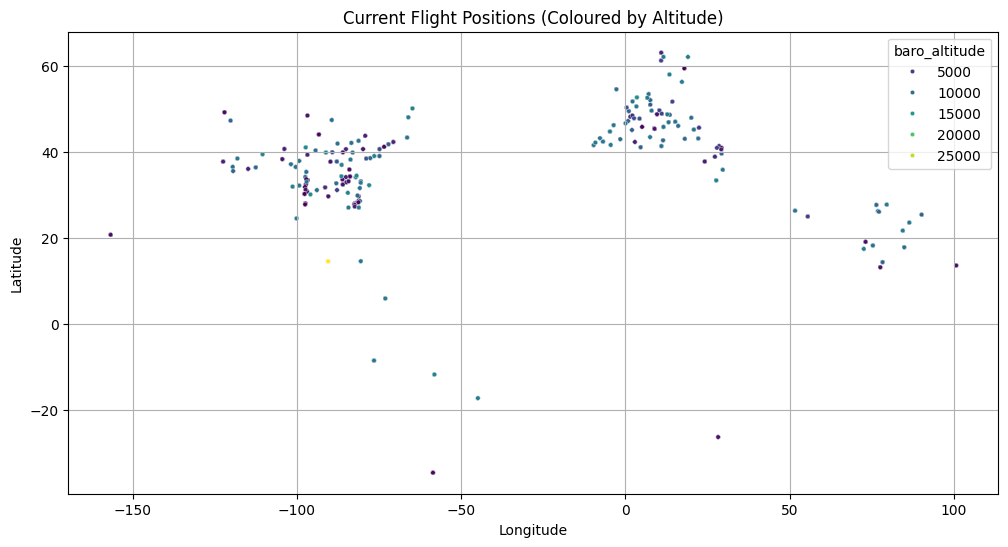

In [10]:
#visulaise the map - see where the planes are

import matplotlib.pyplot as plt
import seaborn as sns

#convert a sample to pandas for plotting
pdf = df_silver.select("long", "lat", "baro_altitude").toPandas()
#pdf

plt.figure(figsize=(12,6))
sns.scatterplot(data = pdf, x = "long", y="lat", hue="baro_altitude", palette="viridis", s=10)
plt.title("Current Flight Positions (Coloured by Altitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [11]:
import plotly.express as px
import nbformat

# 1. Convert Spark DF to Pandas
# We include more columns so we can see them when we hover our mouse over a dot
pdf = df_silver.select("long", "lat", "baro_altitude", "velocity", "callsign", "origin_country").toPandas()

# 2. Create the Map
fig = px.scatter_geo(pdf,
                     lat='lat',
                     lon='long',
                     color="baro_altitude", # Dots change color based on altitude
                     hover_name="callsign", # Shows flight number on hover
                     hover_data=["origin_country", "velocity"],
                     projection="natural earth",
                     title="Live Global Flights - Silver Layer",
                     color_continuous_scale=px.colors.sequential.Plasma)

# 3. Adjust the map look
fig.update_geos(
    showcountries=True, countrycolor="RebeccaPurple",
    showland=True, landcolor="LightGreen",
    showocean=True, oceancolor="LightBlue",
    showlakes=True, lakecolor="Blue"
)

fig.show()

In [12]:
import plotly.express as px
import plotly.io as pio

#look at Europe only
# Filter the Spark DataFrame first
df_europe = df_silver.filter(
    (F.col("lat").between(35, 70)) & 
    (F.col("long").between(-25, 45))
)

#  Convert to Pandas
pdf_europe = df_europe.toPandas()

#  Create the Map
fig = px.scatter_geo(pdf_europe,
                     lat='lat',
                     lon='long',
                     color="baro_altitude",
                     hover_name="callsign",
                     hover_data=["origin_country", "velocity"],
                     scope="europe", # This tells Plotly to focus the camera on Europe
                     title="Live European Flight Traffic",
                     color_continuous_scale="Viridis")

#  Refine the visual details
fig.update_geos(
    resolution=50, # Higher detail for zoomed-in map
    showcoastlines=True, coastlinecolor="Black",
    showland=True, landcolor="white",
    showocean=True, oceancolor="LightBlue",
    showlakes=True, lakecolor="Blue",
    showcountries=True
)

fig.update_layout(height=700, margin={"r":0,"t":50,"l":0,"b":0})

fig.show()